In [57]:
%pip install matplotlib pandas duckdb


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [58]:
import pandas as pd
import duckdb

file_paths = [
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_Before_2010__N__20250810.csv',
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_Between_2010_and_2019__N__20250810.csv',
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_from_2020_to_Present__N__20250810.csv',
]
date_fields = ['SUBMITTED_DATE', 'ISSUE_DATE', 'COFO_DATE', 'STATUS_DATE']
permits_lacity = pd.concat(
    (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
    ignore_index=True,
)
print(permits_lacity.dtypes)

/tmp/ipykernel_15607/332702810.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
/tmp/ipykernel_15607/332702810.py:11: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),


PERMIT_NBR                 object
PRIMARY_ADDRESS            object
ZIP_CODE                  float64
CD                        float64
PIN_NBR                    object
APN                        object
ZONE                       object
APC                        object
CPA                        object
CNC                        object
HL                         object
CT                         object
PERMIT_GROUP               object
PERMIT_TYPE                object
PERMIT_SUB_TYPE            object
USE_CODE                  float64
USE_DESC                   object
SUBMITTED_DATE     datetime64[ns]
ISSUE_DATE         datetime64[ns]
COFO_DATE          datetime64[ns]
DU_CHANGED                float64
ADU_CHANGED               float64
JUNIOR_ADU                float64
SQUARE_FOOTAGE            float64
STATUS_DESC                object
STATUS_DATE                object
VALUATION                 float64
CONSTRUCTION               object
HEIGHT                    float64
TYPE_LAT_LON  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    issue_year  certainly_adu  probably_adu
0         2000            1.0           0.0
1         2010            0.0           1.0
2         2017         1614.0         101.0
3         2018         3277.0         345.0
4         2019         3751.0         354.0
5         2020         2507.0         233.0
6         2021         3577.0         367.0
7         2022         4989.0         383.0
8         2023         4133.0         277.0
9         2024         4108.0         271.0
10        2025         2701.0         162.0


<Axes: xlabel='issue_year'>

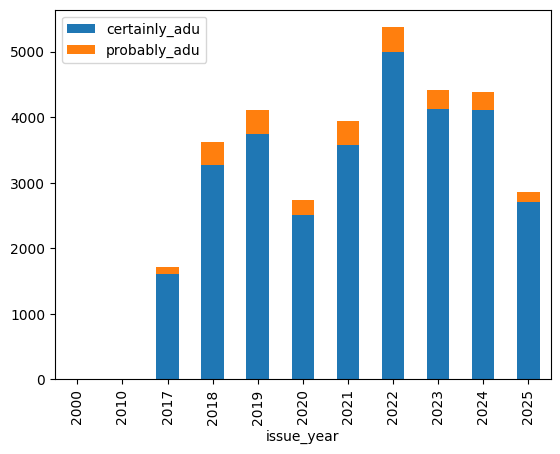

In [59]:
sql_string = """
WITH annotated AS (
  SELECT *,
  
    use_desc in (
      'Accessory Dwelling Unit',
      'Junior Accessory Dwelling Unit'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as certainly_adu,
    
    use_desc in (
      'Apartment',
      'Duplex',
      'Dwelling - Single Family',
      'Garage - Private'
    )
    and (
         work_desc ilike '%(n) adu%'
      or work_desc ilike '%new adu%'
      or work_desc ilike '%one adu%'
      or work_desc ilike '%(n) (% sf) adu%'
      or work_desc ilike '%new (% sf) adu%'
      or work_desc ilike '%one (% sf) adu%'
      or work_desc ilike '%(n) accessory dwelling unit%'
      or work_desc ilike '%new accessory dwelling unit%'
      or work_desc ilike '%one accessory dwelling unit%'
      or work_desc ilike '%(n) (% sf) accessory dwelling unit%'
      or work_desc ilike '%new (% sf) accessory dwelling unit%'
      or work_desc ilike '%one (% sf) accessory dwelling unit%'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as probably_adu,
    
  FROM permits_lacity
)

SELECT year("ISSUE_DATE") as issue_year, sum(certainly_adu) as certainly_adu, sum(probably_adu) as probably_adu
FROM annotated
WHERE certainly_adu or probably_adu
group by issue_year
order by issue_year
"""

adu_permits_issued_by_year = duckdb.query(sql_string).df()
print(adu_permits_issued_by_year)
adu_permits_issued_by_year.plot(x='issue_year', y=['certainly_adu', 'probably_adu'], kind='bar', stacked=True)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   issue_year  adu_count
0        2017       1715
1        2018       3622
2        2019       4105
3        2020       2740
4        2021       3944
5        2022       5372
6        2023       4410
7        2024       4379
8        2025       2863


<Axes: xlabel='issue_year'>

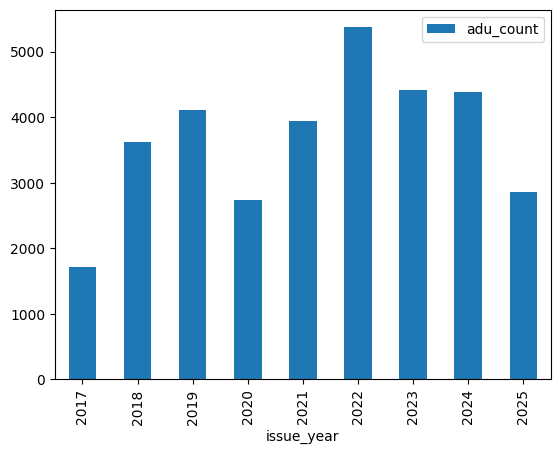

In [60]:
sql_string = """
WITH annotated AS (
  SELECT *,
  
    use_desc in (
      'Accessory Dwelling Unit',
      'Junior Accessory Dwelling Unit'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as certainly_adu,
    
    use_desc in (
      'Apartment',
      'Duplex',
      'Dwelling - Single Family',
      'Garage - Private'
    )
    and (
         work_desc ilike '%(n) adu%'
      or work_desc ilike '%new adu%'
      or work_desc ilike '%one adu%'
      or work_desc ilike '%(n) (% sf) adu%'
      or work_desc ilike '%new (% sf) adu%'
      or work_desc ilike '%one (% sf) adu%'
      or work_desc ilike '%(n) accessory dwelling unit%'
      or work_desc ilike '%new accessory dwelling unit%'
      or work_desc ilike '%one accessory dwelling unit%'
      or work_desc ilike '%(n) (% sf) accessory dwelling unit%'
      or work_desc ilike '%new (% sf) accessory dwelling unit%'
      or work_desc ilike '%one (% sf) accessory dwelling unit%'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as probably_adu,
    
  FROM permits_lacity
)

SELECT year("ISSUE_DATE") as issue_year, count(*) as adu_count
FROM annotated
WHERE certainly_adu or probably_adu
group by issue_year
having adu_count > 1
order by issue_year
"""

adu_permits_issued_by_year = duckdb.query(sql_string).df()
print(adu_permits_issued_by_year)
adu_permits_issued_by_year.plot(x='issue_year', y=['adu_count'], kind='bar')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   issue_year  lacity_adu_permits_issued  saccity_adu_permits_issued  \
0        2017                       1715                          18   
1        2018                       3622                          30   
2        2019                       4105                          57   
3        2020                       2740                          76   
4        2021                       3944                         170   
5        2022                       5372                         259   
6        2023                       4410                         291   
7        2024                       4379                         338   

   lacity_adu_permits_issued_per1k  saccity_adu_permits_issued_per1k  
0                         0.442158                          0.034199  
1                         0.933817                          0.056999  
2                         1.058343                          0.108298  
3                         0.706422                          0.14439

<Axes: xlabel='issue_year'>

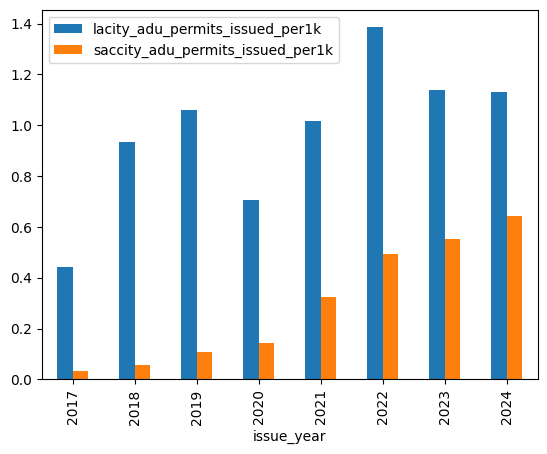

In [61]:
sql_string = """
WITH annotated AS (
  SELECT *,
  
    use_desc in (
      'Accessory Dwelling Unit',
      'Junior Accessory Dwelling Unit'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as certainly_adu,
    
    use_desc in (
      'Apartment',
      'Duplex',
      'Dwelling - Single Family',
      'Garage - Private'
    )
    and (
         work_desc ilike '%(n) adu%'
      or work_desc ilike '%new adu%'
      or work_desc ilike '%one adu%'
      or work_desc ilike '%(n) (% sf) adu%'
      or work_desc ilike '%new (% sf) adu%'
      or work_desc ilike '%one (% sf) adu%'
      or work_desc ilike '%(n) accessory dwelling unit%'
      or work_desc ilike '%new accessory dwelling unit%'
      or work_desc ilike '%one accessory dwelling unit%'
      or work_desc ilike '%(n) (% sf) accessory dwelling unit%'
      or work_desc ilike '%new (% sf) accessory dwelling unit%'
      or work_desc ilike '%one (% sf) accessory dwelling unit%'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as probably_adu,
    
  FROM permits_lacity
)

SELECT year("ISSUE_DATE") as issue_year, count(*) as lacity_adu_permits_issued
FROM annotated
WHERE certainly_adu or probably_adu
group by issue_year
having lacity_adu_permits_issued > 1
order by issue_year
"""

adu_permits_issued_by_year = duckdb.query(sql_string).df()

saccity_adu_permits_issued = pd.DataFrame(
    data={
      'issue_year': [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      'saccity_adu_permits_issued': [18, 30, 57, 76, 170, 259, 291, 338],
    },
)
adu_permits_issued_by_year = adu_permits_issued_by_year.merge(saccity_adu_permits_issued)

lacity_population = 3878704
saccity_population = 526327

adu_permits_issued_by_year['lacity_adu_permits_issued_per1k'] = (
    adu_permits_issued_by_year['lacity_adu_permits_issued'] / lacity_population * 1000
)
adu_permits_issued_by_year['saccity_adu_permits_issued_per1k'] = (
    adu_permits_issued_by_year['saccity_adu_permits_issued'] / saccity_population * 1000
)

print(adu_permits_issued_by_year)
adu_permits_issued_by_year.plot(x='issue_year', y=['lacity_adu_permits_issued_per1k', 'saccity_adu_permits_issued_per1k'], kind='bar')

# Sacramento
---

In [62]:
import pandas as pd
import duckdb

file_paths = [
    'input/sacramento/BldgPermitIssued_Archive_7996043217366564700.csv',
    'input/sacramento/BldgPermitIssued_CurrentYear_1537819314495630354.csv',
]
date_fields = ['Status_Date']
permits_saccity = pd.concat(
    (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
    ignore_index=True,
)
print(permits_saccity.dtypes)

/tmp/ipykernel_15607/1749226553.py:10: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),


OBJECTID                        int64
Type                           object
Sub_Type                       object
Category                       object
Application                    object
Rpt_Status                     object
Status_Date            datetime64[ns]
Current_Status                 object
Parcel_No                      object
Address                        object
Site_Location                  object
ZIP                            object
Inspection_District           float64
House_Count                   float64
Project_Sq_Ft                 float64
Habitable_Sq_Ft               float64
Valuation                     float64
Activity_Code                  object
Contractor                     object
Council_Dist                  float64
Comm_Plan_Area                 object
Work_Desc                      object
Project_Name                   object
dtype: object


In [63]:
permits_saccity['Status_Date']

0        2015-01-01
1        2015-01-02
2        2015-01-02
3        2015-01-02
4        2015-01-02
            ...    
208991   2025-07-25
208992   2025-07-25
208993   2025-07-25
208994   2025-07-26
208995   2025-07-27
Name: Status_Date, Length: 208996, dtype: datetime64[ns]

<Axes: ylabel='Frequency'>

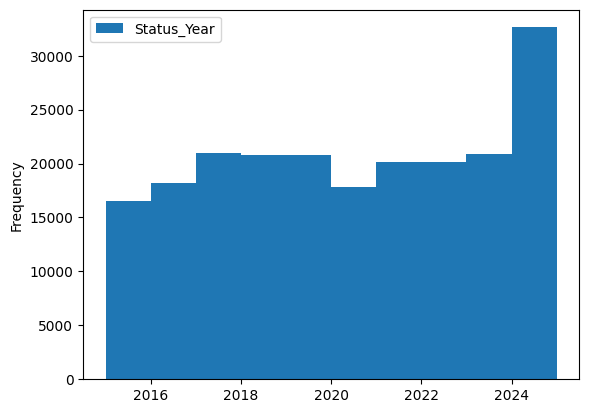

In [64]:
permits_saccity['Status_Year'] = permits_saccity['Status_Date'].dt.year
permits_saccity.plot.hist(column=["Status_Year"])

In [65]:
sql_string = """
WITH annotated AS (
    SELECT *,
  
    Type in (
        'Residential'
    ) and Sub_Type in (
        'New Building'
    ) and Category in (
        'Single Family'
    ) and (
        Work_Desc ilike '%shelf-ready%adu%'
        or Work_Desc ilike '%shelf ready%adu%'
        or Work_Desc ilike '%shelf ready plans%'
        or Work_Desc ilike '%shelf made adu%'
        or Project_Name ilike '%shelf-ready%adu%'
        or Project_Name ilike '%shelf ready%adu%'
        or Project_Name ilike '%shelf ready plans%'
        or Project_Name ilike '%shelf made adu%'
    ) as certainly_shelf_ready_adu,
    
  FROM permits_saccity
)

SELECT year("Status_Date") as status_year, count(*) as saccity_shelf_ready_adu_permits_issued
FROM annotated
WHERE certainly_shelf_ready_adu
group by year("Status_Date") 
having saccity_shelf_ready_adu_permits_issued > 1
order by year("Status_Date") 
"""

saccity_shelf_ready_adu_permits_issued_by_year = duckdb.query(sql_string).df()

<Axes: xlabel='status_year'>

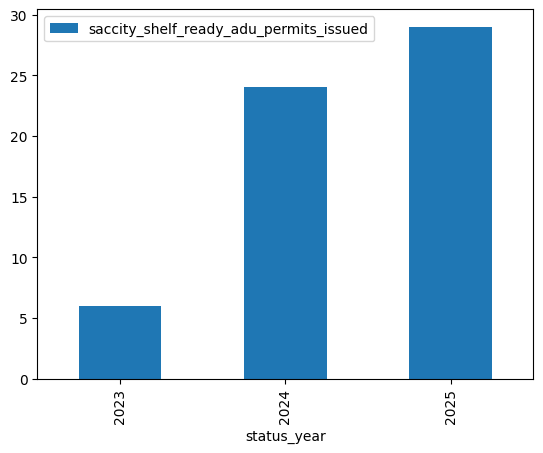

In [66]:
saccity_shelf_ready_adu_permits_issued_by_year.plot(x='status_year', y=['saccity_shelf_ready_adu_permits_issued'], kind='bar')

In [67]:
sql_string = """
WITH annotated AS (
  SELECT *,
  
    Type in (
      'Residential'
    )
    and Sub_Type in (
         'New Building'
    ) and Category in (
         'Single Family'
    ) and (
        Work_Desc ilike '%shelf-ready%adu%'
        or Work_Desc ilike '%shelf ready%adu%'
        or Work_Desc ilike '%shelf ready plans%'
        or Work_Desc ilike '%shelf made adu%'
        or Project_Name ilike '%shelf-ready%adu%'
        or Project_Name ilike '%shelf ready%adu%'
        or Project_Name ilike '%shelf ready plans%'
        or Project_Name ilike '%shelf made adu%'
    ) as certainly_shelf_ready_adu,

    Type in (
      'Residential'
    )
    and Sub_Type in (
         'New Building'
    ) and Category in (
         'Single Family'
    ) and (
        Work_Desc ilike '%adu%'
        or Project_Name ilike '%adu%'
    ) as probably_adu,
    
  FROM permits_saccity
)

SELECT *
FROM annotated
WHERE not certainly_shelf_ready_adu and probably_adu
order by Status_Date desc
"""

probably_adu = duckdb.query(sql_string).df()
for x in probably_adu['Work_Desc']:
    print(x)

EPC - EXPEDITED - New 1 bed 1 bath 361 square foot Detached ADU on upper level with 275 square foot garage on lower level.Carbon monoxide & Smoke alarms required. Reference CRC sections R315 & R314. Water conserving fixtures are required to be installed throughout this residence per SB 407 (Note: Residences built after January 1, 1994 are exempt).
“Any new landscaping done on this property is to be in compliance with the City’s Water Efficient Landscape Ordinance 15.92.”

Demo of 324 square feet, 1 story detached garage on issued permit RES-2500206.
EPC - New 555 s.f. Detached ADU with 1 Bedroom and 1 Bathroom. + 54 S/F Porch/Roof Covering, + 14 S/F Utility Closet with exterior door. Total project 623 S/F. This is a Primary record of Shared Plans. PV Exempt. 
Carbon monoxide & Smoke alarms required. Reference CRC sections R315 & R314. Water conserving fixtures are required to be installed throughout this residence per SB 407 (Note: Residences built after January 1, 1994 are exempt).
“A